# LCCS Level 4 Change Test Notebook

A notebook to take the level 4 classification data for Australia in GeoTiff format and generate change results.

In [1]:
import argparse
import logging
import os
import sys
import yaml

import numpy
import xarray
from matplotlib import pyplot

# Import le_lccs modules
from le_lccs import le_ingest
from le_lccs import le_export

from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4
from le_lccs.le_classification import simple_change

In [2]:
yaml_sites_file = os.path.abspath("../cultivated_ml/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Kakadu"

extent = [site_config[site_name]["min_x"],
          site_config[site_name]["min_y"],
          site_config[site_name]["max_x"],
          site_config[site_name]["max_y"]]

In [3]:
# Set up dictionary to define size parameters
target_size = {}

target_size["target_min_x"] = extent[0]
target_size["target_max_x"] = extent[2]
target_size["target_min_y"] = extent[1]
target_size["target_max_y"] = extent[3]

target_size["target_pixel_size_x"] = 25
target_size["target_pixel_size_y"] = -25

target_size["target_crs"] = "EPSG:3577"

## Data Input

In [4]:
# Set up dictionary with importers for each input layer

level4_tiff_2010 = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/lccs_2010_L4_beta-1.0.2.tif"
level4_tiff_2015 = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Inputs/lccs_2015_L4_beta-1.0.2.tif"

level4_bands = ["level3", "lifeform_veg_cat_l4a", "canopyco_veg_cat_l4d", "watersea_veg_cat_l4a",
                "waterstt_wat_cat_l4a", "waterper_wat_cat_l4d", "inttidal_wat_cat_l4a"]

# Add in all the level4 layers to ingest
input_layers_2010 = {}
input_layers_2015 = {}

for band, layer_name in enumerate(level4_bands):
    input_layers_2010[layer_name] = {}
    input_layers_2015[layer_name] = {}
    
    input_layers_2010[layer_name]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
    input_layers_2010[layer_name]["input_file"] = level4_tiff_2010
    input_layers_2010[layer_name]["resampling"] = "mode"
    input_layers_2010[layer_name]["band"] = band + 1

    input_layers_2015[layer_name]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
    input_layers_2015[layer_name]["input_file"] = level4_tiff_2015
    input_layers_2015[layer_name]["resampling"] = "mode"
    input_layers_2015[layer_name]["band"] = band + 1

## Additional layers
Add in additional layers below as needed. For example:
    
    input_layers_2010["cci_biomass"] = {}
    input_layers_2010["cci_biomass"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
    input_layers_2010["cci_biomass"]["input_file"] = "/path/to/file.tif"
    input_layers_2010["cci_biomass"]["resampling"] = "nearest"
    

In [5]:
#input_layers_2010["cci_biomass"] = {}
#input_layers_2010["cci_biomass"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
#input_layers_2010["cci_biomass"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Gunbower_Change/AGB_2010.tif"
#input_layers_2010["cci_biomass"]["resampling"] = "nearest"

#input_layers_2015["cci_biomass"] = {}
#input_layers_2015["cci_biomass"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
#input_layers_2015["cci_biomass"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Gunbower_Change/AGB_2017.tif"
#input_layers_2015["cci_biomass"]["resampling"] = "nearest"

input_layers_2010["woodyfractn"] = {}
input_layers_2010["woodyfractn"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
input_layers_2010["woodyfractn"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/Kakadu_wcf_2010.tif"
input_layers_2010["woodyfractn"]["resampling"] = "nearest"

input_layers_2015["woodyfractn"] = {}
input_layers_2015["woodyfractn"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
input_layers_2015["woodyfractn"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/Kakadu_wcf_2015.tif"
input_layers_2015["woodyfractn"]["resampling"] = "nearest"

input_layers_2010["burnedareas"] = {}
input_layers_2010["burnedareas"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
input_layers_2010["burnedareas"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/Kakadu_nbr_2010.tif"
input_layers_2010["burnedareas"]["resampling"] = "nearest"

input_layers_2015["burnedareas"] = {}
input_layers_2015["burnedareas"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
input_layers_2015["burnedareas"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/Kakadu_nbr_2015.tif"
input_layers_2015["burnedareas"]["resampling"] = "nearest"

input_layers_2010["waterpersis"] = {}
input_layers_2010["waterpersis"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
input_layers_2010["waterpersis"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/Kakadu_wofs_2010.tif"
input_layers_2010["waterpersis"]["resampling"] = "nearest"

input_layers_2015["waterpersis"] = {}
input_layers_2015["waterpersis"]["ingest_class"] = "gridded_ingest.LEIngestGDAL"
input_layers_2015["waterpersis"]["input_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/Kakadu_wofs_2015.tif"
input_layers_2015["waterpersis"]["resampling"] = "nearest"

In [6]:
# Read each into xarray and save to list
logging.info("Reading in data for 2010")
variables_xarray_list_2010 = []

print("Loading 2010 Data")

for var_name, ingest_parameters in input_layers_2010.items():
    # TODO: Need to write a wrapper to make recursive calls of `getattr` nicer.
    # Don't run any of the 'xarray_maths' classes yet - nead to load all other
    # variables first
    print("Loading: {}".format(var_name))
    import_class_name = ingest_parameters["ingest_class"]
        # Get the class to use for importing
    if import_class_name != "xarray_maths":
        import_class = getattr(getattr(le_ingest, import_class_name.split(".")[0]),
                              import_class_name.split(".")[1])
        # Set up instance of import class
        import_obj = import_class(**target_size)

        # Import
        ingest_parameters["variable_name"] = var_name
        variables_xarray = import_obj.read_to_xarray(**ingest_parameters)
        variables_xarray_list_2010.append(variables_xarray)

# Merge to a single dataset
level4_2010 = xarray.merge(variables_xarray_list_2010)

# Read each into xarray and save to list
logging.info("Reading in data for 2015")
variables_xarray_list_2015 = []

print("Loading 2015 Data")

for var_name, ingest_parameters in input_layers_2015.items():
    # TODO: Need to write a wrapper to make recursive calls of `getattr` nicer.
    # Don't run any of the 'xarray_maths' classes yet - nead to load all other
    # variables first
    print("Loading: {}".format(var_name))
    import_class_name = ingest_parameters["ingest_class"]
        # Get the class to use for importing
    if import_class_name != "xarray_maths":
        import_class = getattr(getattr(le_ingest, import_class_name.split(".")[0]),
                              import_class_name.split(".")[1])
        # Set up instance of import class
        import_obj = import_class(**target_size)

        # Import
        ingest_parameters["variable_name"] = var_name
        variables_xarray = import_obj.read_to_xarray(**ingest_parameters)
        variables_xarray_list_2015.append(variables_xarray)

# Merge to a single dataset
level4_2015 = xarray.merge(variables_xarray_list_2015)

Loading 2010 Data
Loading: level3
Loading: lifeform_veg_cat_l4a
Loading: canopyco_veg_cat_l4d
Loading: watersea_veg_cat_l4a
Loading: waterstt_wat_cat_l4a
Loading: waterper_wat_cat_l4d
Loading: inttidal_wat_cat_l4a
Loading: woodyfractn
Loading: burnedareas
Loading: waterpersis
Loading 2015 Data
Loading: level3
Loading: lifeform_veg_cat_l4a
Loading: canopyco_veg_cat_l4d
Loading: watersea_veg_cat_l4a
Loading: waterstt_wat_cat_l4a
Loading: waterper_wat_cat_l4d
Loading: inttidal_wat_cat_l4a
Loading: woodyfractn
Loading: burnedareas
Loading: waterpersis


## Change Detection

### Simple Level 4 Change

In [7]:
l4_change_codes = simple_change.get_lccs_l4_change_codes(level4_2010, level4_2015, ignore_no_change=False)
l4_change_codes

<xarray.Dataset>
Dimensions:                      (x: 4000, y: 4000)
Coordinates:
  * x                            (x) float64 12.5 37.5 ... 9.996e+04 9.999e+04
  * y                            (y) float64 -1.25e+06 -1.25e+06 ... -1.35e+06
Data variables:
    level3_change                (y, x) uint32 220220 220220 ... 112112 112112
    lifeform_veg_cat_l4a_change  (y, x) uint16 0 0 0 0 0 ... 102 102 202 102 102
    canopyco_veg_cat_l4d_change  (y, x) uint16 0 0 0 0 0 ... 1213 1313 1213 1213
    watersea_veg_cat_l4a_change  (y, x) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    waterstt_wat_cat_l4a_change  (y, x) uint16 101 101 101 101 101 ... 0 0 0 0 0
    waterper_wat_cat_l4d_change  (y, x) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    inttidal_wat_cat_l4a_change  (y, x) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

### Biomass Change

In [8]:
biomass_diff = level4_2010["cci_biomass"].values.astype(numpy.float32) - level4_2015["cci_biomass"].values.astype(numpy.float32)

# Convert numpy array with change values into an xarray Dataset
biomass_diff_xarray = xarray.Dataset(
    {"cci_biomass_diff" : (level4_2010["cci_biomass"].dims, biomass_diff)},
    coords=level4_2010.coords)

KeyError: 'cci_biomass'

In [9]:
# Merge into a single xarray
l4_change_codes = xarray.merge([l4_change_codes, biomass_diff_xarray])

NameError: name 'biomass_diff_xarray' is not defined

### Woody Fraction Change

In [10]:
woodyfr_diff = level4_2010["woodyfractn"].values.astype(numpy.float32) - level4_2015["woodyfractn"].values.astype(numpy.float32)

# Convert numpy array with change values into an xarray Dataset
woodyfractn_diff_xarray = xarray.Dataset(
    {"woodyfractn_diff" : (level4_2010["woodyfractn"].dims, woodyfr_diff)},
    coords=level4_2010.coords)

In [11]:
# Merge into a single xarray
l4_change_codes = xarray.merge([l4_change_codes, woodyfractn_diff_xarray])

###  Burned area change (Based on Normalised Burn Index - NBI)

In [12]:
burnedarea_diff = level4_2010["burnedareas"].values.astype(numpy.float32) - level4_2015["burnedareas"].values.astype(numpy.float32)

# Convert numpy array with change values into an xarray Dataset
burnedareas_diff_xarray = xarray.Dataset(
    {"burnedareas_diff" : (level4_2010["burnedareas"].dims, burnedarea_diff)},
    coords=level4_2010.coords)

In [13]:
# Merge into a single xarray
l4_change_codes = xarray.merge([l4_change_codes, burnedareas_diff_xarray])

### Water hydroperiod Change


In [14]:
waterpersis_diff = level4_2010["waterpersis"].values.astype(numpy.float32) - level4_2015["waterpersis"].values.astype(numpy.float32)

# Convert numpy array with change values into an xarray Dataset
waterpersis_diff_xarray = xarray.Dataset(
    {"waterpersis_diff" : (level4_2010["waterpersis"].dims, waterpersis_diff)},
    coords=level4_2010.coords)

In [15]:
# Merge into a single xarray
l4_change_codes = xarray.merge([l4_change_codes, waterpersis_diff_xarray])

In [16]:
# Export data as a GeoTiff

export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/{}_2010-2015_l4_change.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.float32
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(l4_change_codes, **export_parameters)

### Evidence Based Change - Severe Wildfire
Wildfire has change code 1.

* Need Level3 to have stayed as 112
* Canopy Cover category 10 -> 16
* Woody fraction decreases
* NBR increases
* Decrease in AGB (not available for 2019/20-20)

If changes in above, this gives the reason for the change (i.e., severe wildfire). The pressure is fire in this case. The consequence is loss of carbon and biodiverity (refer to pre-fire conditions)


In [17]:
severe_wild_fire = numpy.where((l4_change_codes["level3_change"].values == 112112) &
                        (l4_change_codes["canopyco_veg_cat_l4d_change"].values == 1212) &
                        (l4_change_codes["woodyfractn_diff"].values >=0.1) &
                        (l4_change_codes["burnedareas_diff"].values >=0.2), 1, 0)

In [18]:
# Convert to xarray
severe_wild_fire_xarray = xarray.Dataset(
    {"severe_wild_fire" : (level4_2010["level3"].dims, severe_wild_fire)},
    coords=level4_2010.coords)

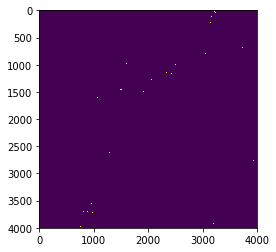

In [19]:
pyplot.imshow(severe_wild_fire)

In [20]:
# Export data as a GeoTiff
export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/{}_2010-2015_severe_fire.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.uint16
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(severe_wild_fire_xarray, **export_parameters)

### Evidence Based Change - Vegetation Reduction

Vegetation reduction has change code 1.

* Need Level3 to have stayed as 112
* Canopy Cover category to have reduced
* (Biomass to have reduced)

1010 : ("Remained as closed (> 60-70 %) (A10)")
1212 : ("Remained as open (40 to 60-70 %) (A12)")
1313 : ("Remained as open (10 to 20-40 %) (A13)")
1515 : ("Remained as sparse (4 to 10-20 %) (A15)")
1616 : ("Remained as scattered (1 to 4 %) (A16)")

In [21]:
veg_red = numpy.where((l4_change_codes["level3_change"].values == 112112) &
                    (l4_change_codes["canopyco_veg_cat_l4d_change"].values == 1012), 1, 0)

In [22]:
# Convert to xarray
veg_red_xarray = xarray.Dataset(
    {"veg_red" : (level4_2010["level3"].dims, veg_red)},
    coords=level4_2010.coords)

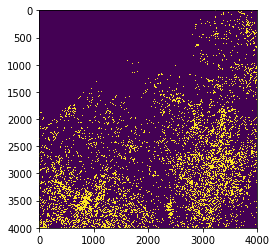

In [23]:
pyplot.imshow(veg_red)

In [24]:
# Export data as a GeoTiff
export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/{}_2010-2015_veg_red.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.uint16
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(veg_red_xarray, **export_parameters)

### Evidence Based Change - Mangrove Dieback

Dieback has a code of 1

* Need Level3 to have stayed as 112
* Canopy Cover category to have reduced
"Remained as closed (> 60-70 %) (A10)"
"Remained as open (40 to 60-70 %) (A12)"
"Remained as open (10 to 20-40 %) (A13)"
"Remained as sparse (4 to 10-20 %) (A15)"
"Remained as scattered (1 to 4 %) (A16)"
* Biomass to have reduced

In [25]:
dieback = numpy.where((l4_change_codes["level3_change"].values == 124124) &
                    (l4_change_codes["canopyco_veg_cat_l4d_change"].values == 1013), 1, 0)

In [26]:
 # Convert to xarray
dieback_xarray = xarray.Dataset(
    {"dieback" : (level4_2010["level3"].dims, dieback)},
    coords=level4_2010.coords)
    

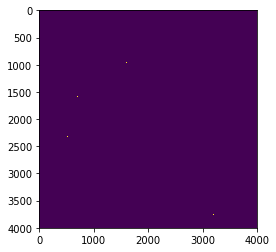

In [27]:
pyplot.imshow(dieback)

In [28]:
# Export data as a GeoTiff

export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/{}_2010-2015_l4_dieback.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.float32
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(dieback_xarray, **export_parameters)

# Evidence Based Change - Water reduction
Need Level3 to have stayed as 220
Water persistence needs to change between each of these

"Perennial (> 9 months) (B1)"
"Non-perennial (< 9 months) (B2)"
"Perennial (7-9 months) (B7)"
"Perennial (4-6 months) (B8)"
"Perennial (1-3 months) (B9)"

In [29]:
water_change = numpy.where((l4_change_codes["level3_change"].values == 220220) &
                        (l4_change_codes["waterpersis_diff"].values >= 0.02), 1, 0)

In [30]:
# Convert to xarray
water_change_xarray = xarray.Dataset(
    {"water_change" : (level4_2010["level3"].dims, water_change)},
    coords=level4_2010.coords)

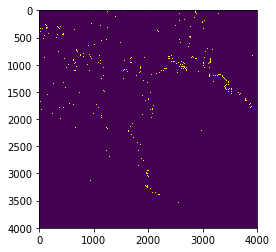

In [31]:
pyplot.imshow(water_change)

In [32]:
# Export data as a GeoTiff
export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/Kakadu_Change/{}_2010-2015_hydroperiod_decrease.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.uint16
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(water_change_xarray, **export_parameters)

### AEM: Wet-Dry Tropical Eucalypt Woodlands
Archetype: Most wet-dry tropical woodlands comprise mixed age tree stands dominated by eucalypts (Eucalyptus spp. and Corymbia spp.) with a grassy understorey. These tropical eucalypt species are highly tolerant of the frequent, relatively low intensity of fires that dominate the wet-dry tropical landscapes.

1) Bimodal Savanna woodland with large trees and even-age recruits
2) Old shrubby woodland
3) Mixed-size resprouting savanna
4) Transition to monsoon forest or vine thicket

##### Canopy cover (%): 10: Closed (> 60-70 %) (A10), 12: Open (40 to 60-70 %) (A12), 13: Open (10 to 20-40 %) (A13),15: Sparse (4 to 10-20 %) (A15), 16: Scattered (1 to 4 %) (A16); Woody Fraction (%): 0 to 0.1 (representing 0 to 100 %), Above ground biomass (Mg ha-1): 0 to 300 Mg ha-1,Frequency of burn (number): 0 to 35+, Time since last burn (years): 0 to 35 years

#### Expression - bimodal savanna woodland with large trees and even age recruits
In some circumstances, fire regimes can lead to ecosystems dominated by larger trees with relatively fewer small to intermediate trees. Large scale disturbances such as regional droughts and hot fires can subsequently lead to pulsed recruitment and the development of stands with a bimodal size class distribution.

In [35]:
bimodal = numpy.where((level4_2010["level3"].values == 112) &
                      (level4_2010["canopyco_veg_cat_l4d"].values == 10) &
                      ((level4_2010["woodyfractn"].values >= 0.3) & (level4_2010["woodyfractn"].values <= 0.4)), 1, 0)

In [36]:
 # Convert to xarray
biomodal_xarray = xarray.Dataset(
    {"bimodal" : (level4_2010["level3"].dims, bimodal)},
    coords=level4_2010.coords)

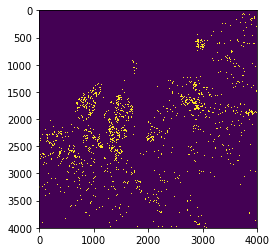

In [37]:
pyplot.imshow(bimodal)

#### Expression - old shrubby woodland
In some circumstances, fire regimes can lead to ecosystems dominated by larger trees with relatively fewer small to intermediate trees. Large scale disturbances such as regional droughts and hot fires can subsequently lead to pulsed recruitment and the development of stands with a bimodal size class distribution.  Longer fire free intervals promote shrub growth in many ecosystems, especially those with sandy soils. Under these circumstances, grass growth may be suppressed.
1010 : ("Remained as closed (> 60-70 %) (A10)"),
1212 : ("Remained as open (40 to 60-70 %) (A12)"),
1313 : ("Remained as open (10 to 20-40 %) (A13)"),
1515 : ("Remained as sparse (4 to 10-20 %) (A15)"),
1616 : ("Remained as scattered (1 to 4 %) (A16)"),

In [38]:
oldshrubby = numpy.where((level4_2010["level3"].values == 112) &
                      (level4_2010["canopyco_veg_cat_l4d"].values ==12) &
                      (level4_2010["woodyfractn"].values >= 0.4 ), 1, 0)

In [39]:
# Convert to xarray
oldshrubby_xarray = xarray.Dataset(
    {"bimodal" : (level4_2010["level3"].dims, bimodal)},
    coords=level4_2010.coords)

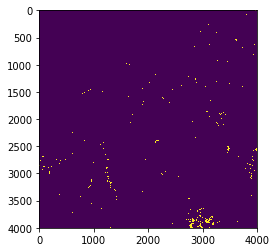

In [40]:
pyplot.imshow(oldshrubby)

In [41]:
# Export data as a GeoTiff

export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/{}_2010-Old_shrubby_woodland.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.float32
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(oldshrubby_xarray, **export_parameters)

#### Expression - mixed-sized resprouting savanna
Cyclonic winds cause savanna trees to be uprooted or snapped and the subsequent fires can then kill damaged trees. Such disturbances lead to pulsed recruitment as can be seen in stand structures.

In [42]:
mixedsize_resprout = numpy.where((level4_2010["level3"].values == 112) &
                      (level4_2010["canopyco_veg_cat_l4d"].values ==13) &
                      ((level4_2010["woodyfractn"].values >= 0.1)& (level4_2010["woodyfractn"].values <= 0.3)), 1, 0)

In [43]:
# Convert to xarray
mixedsize_resprout_xarray = xarray.Dataset(
    {"bimodal" : (level4_2010["level3"].dims, mixedsize_resprout)},
    coords=level4_2010.coords)

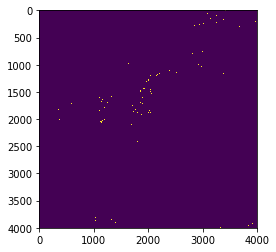

In [44]:
pyplot.imshow(mixedsize_resprout)

In [45]:
# Export data as a GeoTiff

export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/{}_2010-Mixedsize_resprout_woodland.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.float32
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(mixedsize_resprout_xarray, **export_parameters)

#### Expression - Transition to monsoon forest or vine thicket
Eucalypt-dominant savannas are rarely observed to transition to other vegetation types. Long fire-free periods (decades to centuries) can lead to conversion to monsoon forest or vine thicket and the probability of this conversion is greater at higher rainfall

In [46]:
monsoon_vine = numpy.where((level4_2010["level3"].values == 112) &
                      (level4_2010["canopyco_veg_cat_l4d"].values ==13) &
                      ((level4_2010["woodyfractn"].values >= 0.1) & (level4_2010["woodyfractn"].values <= 0.3)), 1, 0)

In [47]:
 # Convert to xarray
monsoon_vine_xarray = xarray.Dataset(
    {"monsoon_vine" : (level4_2010["level3"].dims, monsoon_vine)},
    coords=level4_2010.coords)

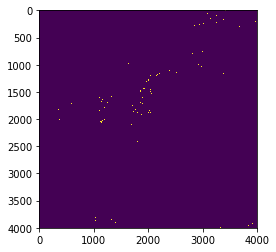

In [48]:
pyplot.imshow(monsoon_vine)

In [49]:
# Export data as a GeoTiff
export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/{}_2010-MonsoonForest_vinethicket.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.float32
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(monsoon_vine_xarray, **export_parameters)

### AEM Transitions - Wet-Dry Tropical Eucalypt Woodlands 

In [51]:
biomodal_to_oldshrubby = numpy.where((l4_change_codes["level3_change"].values == 112112) &
                        (l4_change_codes["canopyco_veg_cat_l4d_change"].values == 1212) &
                        (l4_change_codes["woodyfractn_diff"].values >=0.1), 1, 0)

In [52]:
 # Convert to xarray
biomodal_to_oldshrubby_xarray = xarray.Dataset(
    {"biomodal_to_oldshrubby" : (level4_2010["level3"].dims, biomodal_to_oldshrubby)},
    coords=level4_2010.coords)

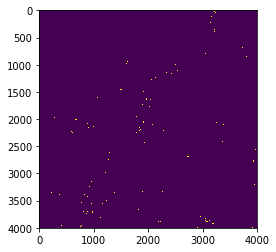

In [53]:
pyplot.imshow(biomodal_to_oldshrubby)

In [54]:
# Export data as a GeoTiff
export_parameters = {}
export_parameters["output_file"] = "/Users/richard/Dropbox (EOED)/Data_Projects/DEA_LandCoverMonitoring/Change/{}_2010-2015-biomodal_to_oldshrubby.tif".format(site_name.replace(" ","_"))
# Use a float for output and cast all output layer to this
export_parameters["out_dtype"] = numpy.float32
export_parameters["cast_to_out_dtype"] = True
# Get export class to use
export_class = le_export.gridded_export.LEExportGDAL

export_obj = export_class(**target_size)

# Write out xarray
export_obj.write_xarray(biomodal_to_oldshrubby_xarray, **export_parameters)